# Taller 4 - Alternativo - Flujo Flowers
- Sebastián Castellano Estupiñan
- Ricardo Andrés Cortés Coronell
- Andrés Felipe Sanchez Rincón

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt

c:\Users\ASUS Vivobook\anaconda3\envs\BigDataPipelines\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ASUS Vivobook\anaconda3\envs\BigDataPipelines\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ASUS Vivobook\anaconda3\envs\BigDataPipelines\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:
# Cargar el dataset de flores
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True,
)

In [4]:
# Definir tamaño de imagen y normalizar
IMG_SIZE = 180
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    return image, label

# Mapeo de la función a los datasets
ds_train = ds_train.map(format_image).cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(format_image).batch(32).cache().prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(format_image).batch(32).cache().prefetch(tf.data.AUTOTUNE)

# Se obtienen los nombres de las clases
class_names = ds_info.features['label'].names
print("Clases:", class_names)

Clases: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
def build_flower_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    # Capa de aumento de datos
    model.add(keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]))

    # Ajuste de filtros para la primera capa convolucional
    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    model.add(layers.Conv2D(hp_filters_1, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    # Ajuste de filtros para la segunda capa convolucional
    hp_filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)
    model.add(layers.Conv2D(hp_filters_2, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())
    
    # Ajuste de unidades en la capa densa
    hp_units = hp.Int('units', min_value=128, max_value=512, step=128)
    model.add(layers.Dense(units=hp_units, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    # Capa de salida con 5 clases
    model.add(layers.Dense(len(class_names), activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    
    return model

In [8]:
tuner_flowers = kt.Hyperband(build_flower_model,
                                objective='val_accuracy',
                                max_epochs=15,
                                factor=3,
                                directory='flowers_tuning',
                                project_name='tf_flowers_tuning')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner_flowers.search(ds_train, epochs=30, validation_data=ds_val, callbacks=[stop_early])

best_hps_flowers = tuner_flowers.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejores hiperparámetros encontrados para el dataset de flores.")

Reloading Tuner from flowers_tuning\tf_flowers_tuning\tuner0.json
Mejores hiperparámetros encontrados para el dataset de flores.


Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.4545 - loss: 2.3932 - val_accuracy: 0.6055 - val_loss: 1.0425
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5670 - loss: 1.0869 - val_accuracy: 0.6055 - val_loss: 0.9734
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.6237 - loss: 0.9750 - val_accuracy: 0.6582 - val_loss: 0.8883
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.6481 - loss: 0.9198 - val_accuracy: 0.6291 - val_loss: 0.9588
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.6731 - loss: 0.8603 - val_accuracy: 0.6545 - val_loss: 0.8843
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.6952 - loss: 0.8164 - val_accuracy: 0.6764 - val_loss: 0.7852
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.7074 - loss: 0.7582 - val_accuracy: 0.6673 - val_loss: 0.8395
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.7244 - loss: 0.7296 - val_accuracy: 0.7018 - v

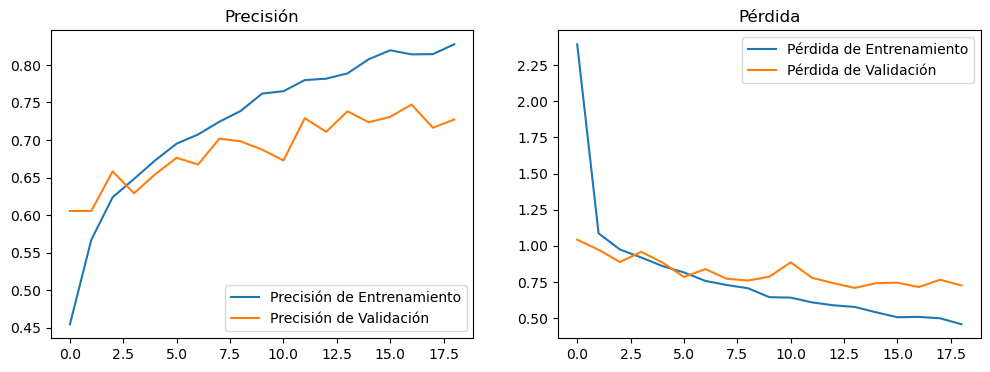

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


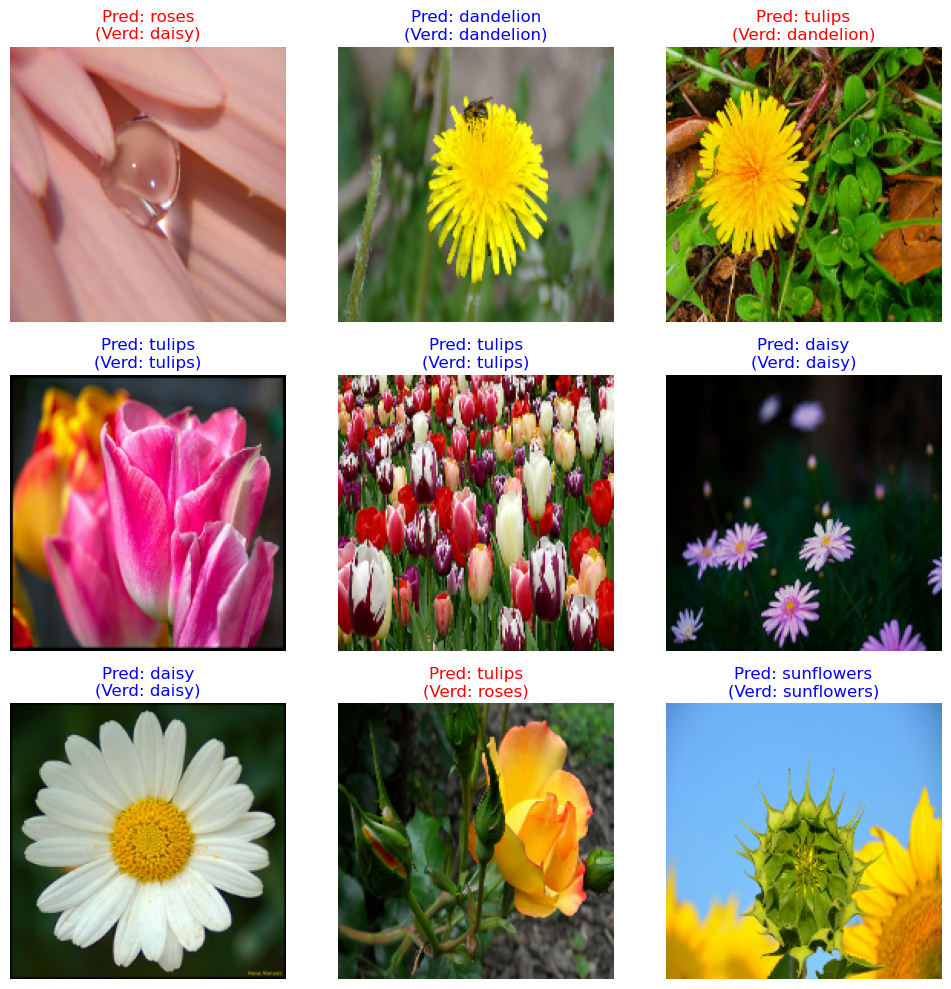

In [7]:
# Construir y entrenar el modelo final
final_flower_model = tuner_flowers.hypermodel.build(best_hps_flowers)
ds_train_full_flowers = ds_train.concatenate(ds_val)

history_flowers = final_flower_model.fit(
    ds_train_full_flowers,
    epochs=50,
    validation_data=ds_test,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluar
test_loss, test_acc = final_flower_model.evaluate(ds_test)
print(f'\nPrecisión en el conjunto de prueba de flores: {test_acc:.4f}')

def plot_history(history_flowers):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_flowers.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history_flowers.history['val_accuracy'], label='Precisión de Validación')
    plt.legend()
    plt.title('Precisión')
    plt.subplot(1, 2, 2)
    plt.plot(history_flowers.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history_flowers.history['val_loss'], label='Pérdida de Validación')
    plt.legend()
    plt.title('Pérdida')
    plt.show()

plot_history(history_flowers)

# Visualizar predicciones
plt.figure(figsize=(10, 10))
for images, labels in ds_test.take(1):
    predictions = final_flower_model.predict(images)
    for i in range(9): # Visualizar 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        predicted_label = np.argmax(predictions[i])
        true_label = labels[i]
        
        color = 'blue' if predicted_label == true_label else 'red'
        plt.title(f"Pred: {class_names[predicted_label]}\n(Verd: {class_names[true_label]})", color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()